In [0]:
import tensorflow as tf
import math
# !pip install -U git+https://github.com/PYFTS/pyFTS
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import SimpleRNN
from keras.layers import Dropout
from keras.layers import Activation
from keras.layers import Flatten
from keras.optimizers import RMSprop

import pandas as pd
import numpy
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [0]:
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back)]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return numpy.array(dataX), numpy.array(dataY)

Building model...
Epoch 02215: early stopping
Train Score: 0.88 RMSE
Test Score: 2.64 RMSE
Result for LSTM 2 3250 epochs without activation function


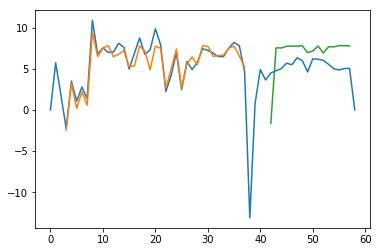

In [54]:
# Dataset Preprocessing
df = pd.read_csv("API_IDN_DS2_en_csv_v2_10516736.csv")
main_df = pd.DataFrame(df)
gdp = main_df[main_df['Indicator Code'] == "NY.GDP.MKTP.KD.ZG"]
gdp = gdp.fillna(0)
gdp = gdp[gdp.columns.drop(list(df.filter(regex='Unnamed')))]
gdp = gdp.drop(gdp.iloc[:, 0:4], axis = 1)
gdp = pd.melt(gdp)
gdp = gdp.drop(gdp.columns[0], axis = 1)
dataset = gdp

# inflat = main_df[main_df['Indicator Code'] == 'NY.GDP.DEFL.KD.ZG']
# inflat = inflat.fillna(0)
# inflat = inflat[inflat.columns.drop(list(df.filter(regex='Unnamed')))]
# inflat = inflat.drop(inflat.iloc[:, 0:4], axis = 1)
# inflat = pd.melt(inflat)
# inflat = inflat.drop(inflat.columns[0], axis = 1)

# dataset = pd.concat([gdp, inflat], axis=1)

# Fix random seed for reproducibility
numpy.random.seed(7)

# Normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

# Split into train & test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]

# Reshape into X=t and Y=t+1
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# Reshape input to be [samples, timesteps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

# Create and fit the LSTM Network
model = Sequential()
model.add(SimpleRNN(256, return_sequences=True, input_shape=(1, look_back)))
model.add(Dropout(0.1))
model.add(SimpleRNN(128, return_sequences=True, input_shape=(1, look_back)))
model.add(Dropout(0.1))
model.add(SimpleRNN(64))
model.add(Dense(1))
model.add(Activation('tanh'))
print("Building model...")
es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=500)
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(trainX, trainY, epochs=2338, batch_size=1, verbose=0, callbacks=[es])

# Make Prediction
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# Invert Prediction
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

# Calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print("Train Score: %.2f RMSE" % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:, 0]))
print("Test Score: %.2f RMSE" % (testScore))

# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

print("Result for LSTM 2 3250 epochs without activation function")
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()